# 1.7 Small World Network (or "six degrees of separation")

This notebook shows the solution to Exercise 1.7 from Sethna's book on Statistical mechanics, the idea is creating software that models small world networks and exploring its properties.

## a) Define and show a network object on the computer

The SmallNetwork.py code is completely my "invention", while the NetGraphics code (check the github repository at https://github.com/ijpulidos/StatMech ) is from Sethna's website, I just changed some things to work with recent versions of python3, Pillow and my SmallNetwork code.

The SmallNetwork.py code defines and has the basic functions for the SmallNetwork (graph). The NetGraphics.py code draws the network.

In [1]:
import SmallNetwork  # Local dir lib
import NetGraphics  # Local dir lib 
import numpy as np
import matplotlib.pyplot as plt  # For plotting historgrams and more
import matplotlib.ticker as mtick  # For playing with ticks in figures
from matplotlib import gridspec  # For changing sizes of different subplots

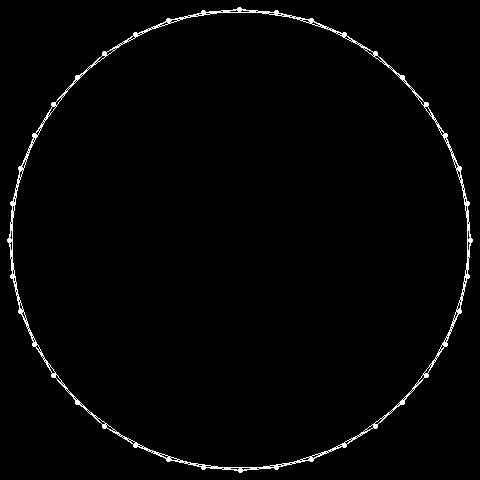

In [2]:
network = SmallNetwork.SmallNetwork(40, 4, 0.0)
NetGraphics.GenerateCircleGraphImage(network, "/tmp/prueba.png")
# NetGraphics.Display("/tmp/prueba.png")

## b) Finding and analyzing path length distribution

The idea is to use a *breadth-first* algorithm to compute and save the distances between nodes, just as the book suggests. Now, I did have trouble understanding what the algorithm really does... this should help: https://en.wikipedia.org/wiki/Breadth-first_search

The key aspect is storing the visited nodes and checking if you have already visited the node, then if you just check all the neighbors of all the nodes you get the distance to every node in the network from a given source node, it helps that the network has all the nodes connected one way or the other (ie. there's always a path from one node to any other node). This little animation should help visualizing the algorithm:
<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Animated_BFS.gif">

In [3]:
def FindPathLengthsFromNode(graph, node):
    lengths = {} # Dictionary that will store lenghts from specified node
    l = 0  # Initialize length as zero
    lengths[node] = 0  # Put the length in the correct index (which represents a node) 
                         # lengths[node]-> shortest length to node from origin/source
    currentShell = [node]  # Initialize currentShell to [node]
    while(True):
        if len(lengths) == len(graph.nodes):
            return lengths
        else:
            nextShell = []  # Restarting next shell in main loop
            for node_ in currentShell:
                for neighbor in graph.get_neighbors(node_):
                    if neighbor not in lengths:  # Verify that neighbor node has not been visited
                        # Add neighbors of node_ to nextShell
                        nextShell.append(neighbor)
                        # Set distance to node to l+1
                        lengths[neighbor] = l+1
            l+=1
            currentShell = nextShell  # Update shell

In [4]:
def FindAllPathLengths(graph):
    """
    Generates a list of all lengths (one per pair of nodes in the graph).
    """
    all_lengths = []  # List to store ALL path lengths
    for node in graph.nodes:
        lengths_from_node = FindPathLengthsFromNode(graph, node)  # This is a dict
        for length in lengths_from_node.values():
            all_lengths.append(length)
    return all_lengths

In [5]:
def FindAveragePathLength(graph):
    all_lengths_test =FindAllPathLengths(graph)
    return np.mean(all_lengths_test)

## c) Watts and Stogratz diagram

Now we try to reproduce the work done by Watts and Stogratz in their famous paper. Check http://worrydream.com/refs/Watts-CollectiveDynamicsOfSmallWorldNetworks.pdf

Plotting the average length between nodes $l(p)$ divided by $l(p=0)$ for $Z=2$, $L=50$ on a semilog from $p=0.001$ to $p=1$

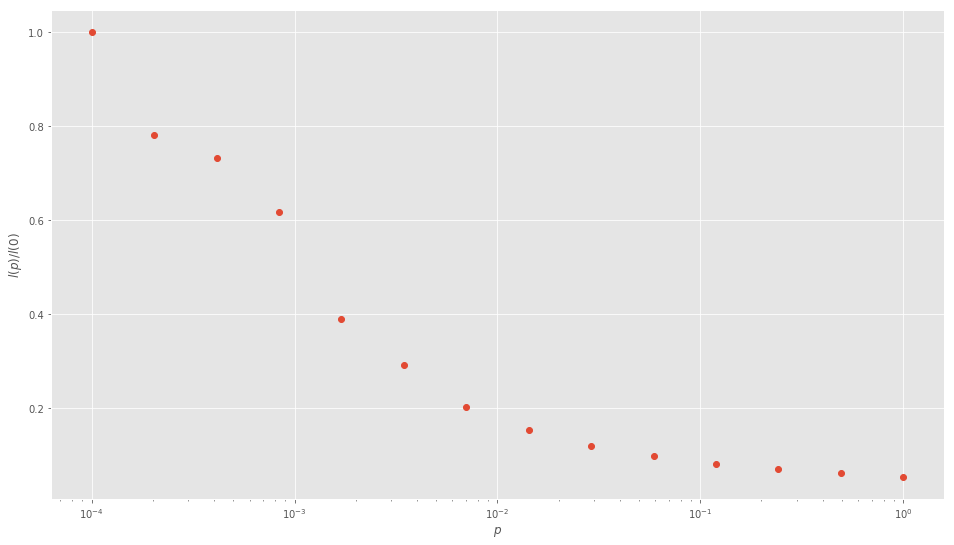

In [42]:
#%%timeit
Z = 10
L = 1000
N = 10  # Number of samples for each average, for better statistics
probabilities = np.logspace(-4,0,14)  # Probabilities evenly spaced in logspace
network_base = SmallNetwork.SmallNetwork(L, Z, 0.)
all_lengths_base = FindAllPathLengths(network_base)
average_base = np.average(all_lengths_base)
average_path_lengths = []  # Where to store the normalized average path lengths
for p in probabilities:
    temp_averages = []
    for i in range(N):  # Take average N times for each p
        normalized_lengths = []  # Temporal array to store all path lengths for each p
        network = SmallNetwork.SmallNetwork(L, Z, p)
        all_lengths = FindAllPathLengths(network)
        temp_averages.append(np.mean(all_lengths))
    temp_averages = np.array(temp_averages)
    temp_averages = temp_averages/average_base  # Divide by l(p=0)
    average_path_lengths.append(np.mean(temp_averages))

# Plotting
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(16,9))
plt.semilogx(probabilities, average_path_lengths, 'o')
plt.xlabel(r'$p$')
plt.ylabel(r'$l(p)/l(0)$')
plt.show()


## Appendix A: Histograms
Now we make a histogram of all the path lengths in the network/graph, test case is with p=0 (that means, only short edges, no random paths).

We make various histograms for different bin sizes, to check how histograms can lead to faulty conclusions.

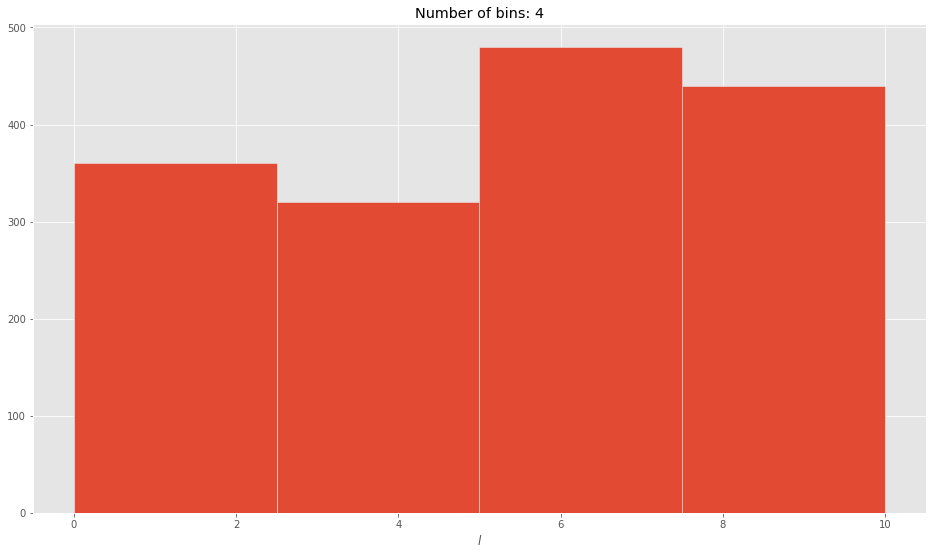

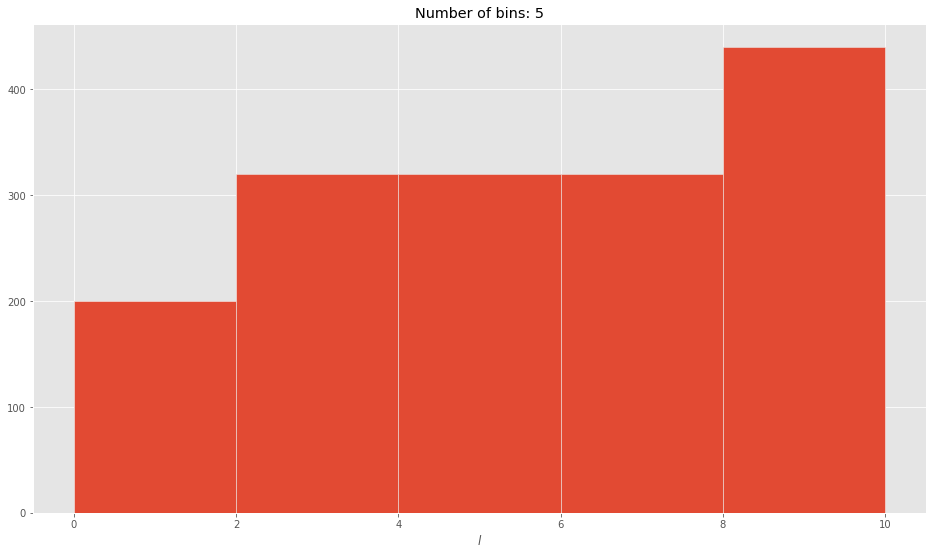

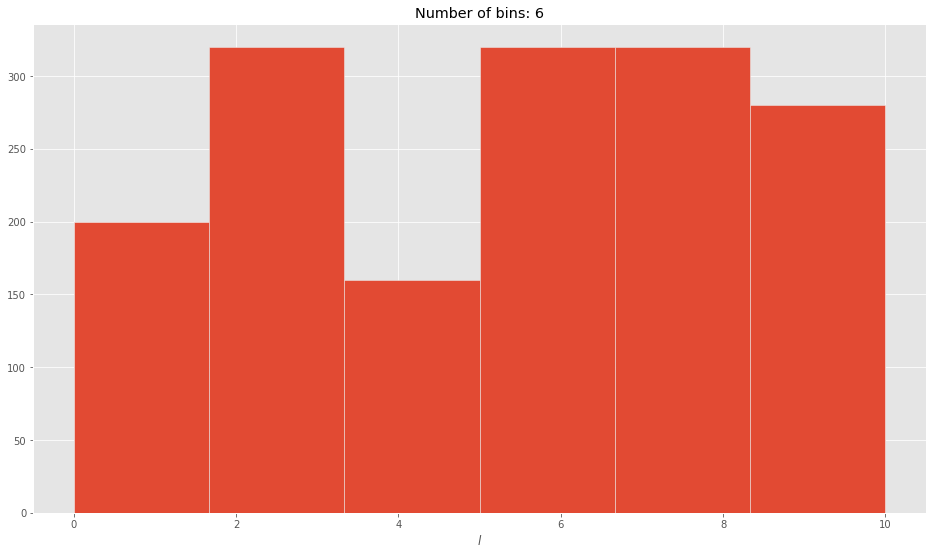

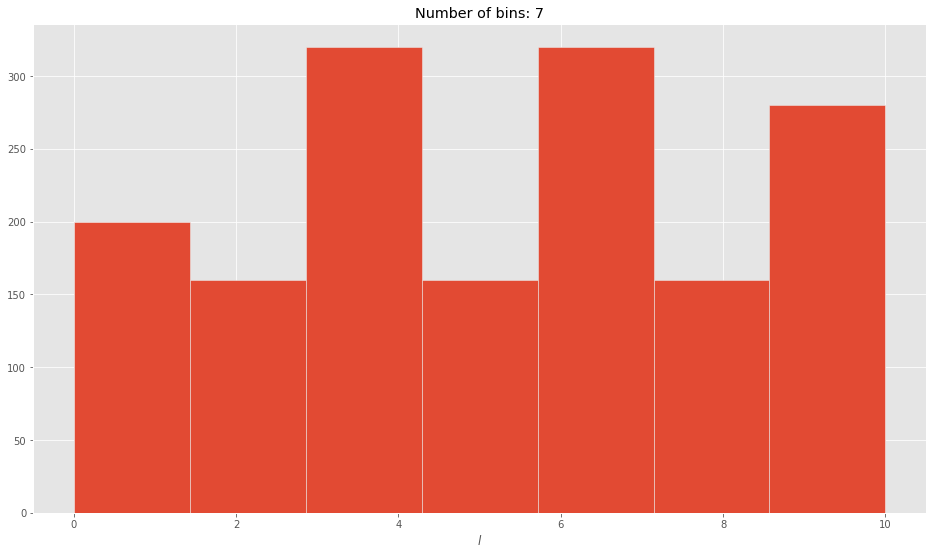

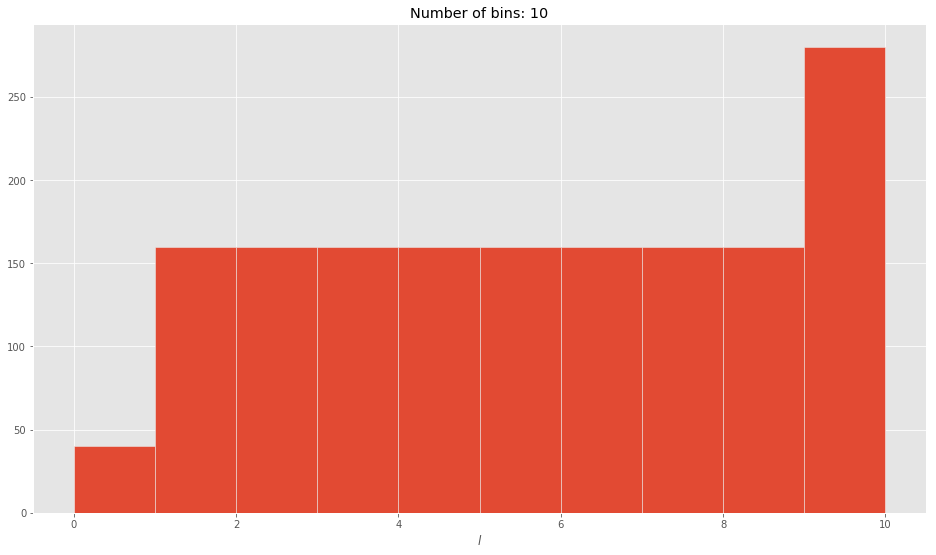

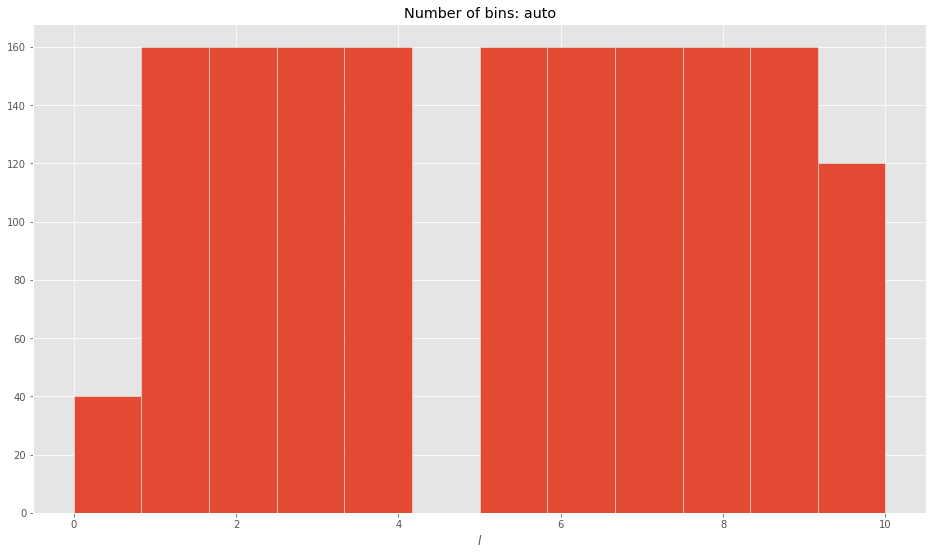

In [23]:
network = SmallNetwork.SmallNetwork(40, 4, 0.0)
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('ggplot')
all_lengths = FindAllPathLengths(network)
#plt.figure(figsize=(16,9))
#for i in [5, 7, 9, 10, 12, "auto"]:
# sqrt, sturges, rice
for i in [4,5, 6, 7, 10, "auto"]:
    plt.figure(figsize=(16,9))
    plt.hist(all_lengths, bins=i)
    plt.title("Number of bins: " + str(i))
    plt.xlabel(r"$l$")
plt.show()


We expected the histogram (distribution) to be constant for $ 0 < l < L/Z $, but you see how that depends on the histogram bin size, that's how "histograms can lie" and makes us reach to faulty conclusions. You always have to check different bin sizes (among other things)

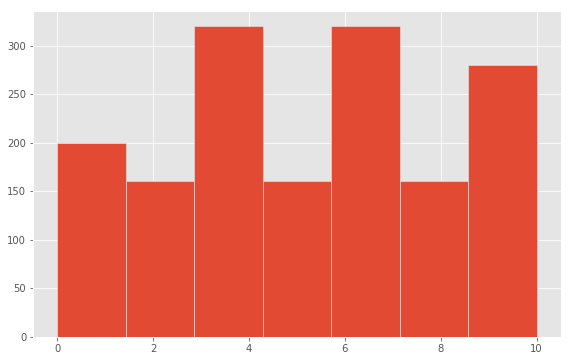

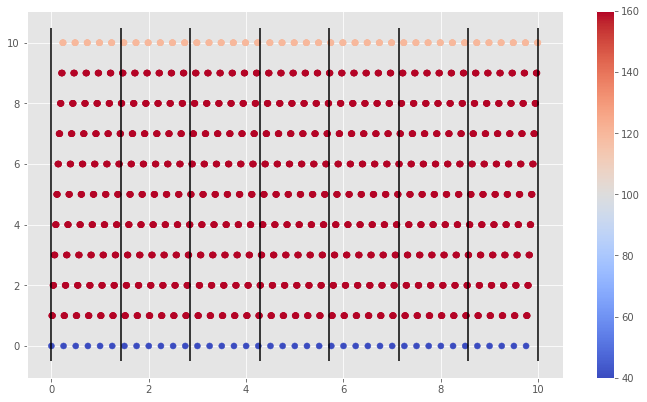

In [24]:
# Histograms lie
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('ggplot')
all_lengths = FindAllPathLengths(network)

# Plot histogram
plt.figure(figsize=(9.45,6))  # done by hand to try to match first figure (hist) with last one (dot diagram)
n, bins, count = plt.hist(all_lengths, bins=7)
#plt.ticklabel_format(style='sci', axis='y')


# Plot dot diagram
# Another approach with sizes for repeated values
size_constant = 0.0001
plt.figure(figsize=(12,6.75))
np_all_lengths = np.array(all_lengths)
X = np.linspace(0,10,len(all_lengths))

sizes = [all_lengths.count(num)**2.5*size_constant for num in all_lengths]
color = [all_lengths.count(num)*1 for num in all_lengths]
plt.scatter(X, all_lengths, c=color, cmap="coolwarm")
plt.vlines(bins,-0.5,10.5)
plt.colorbar()

plt.show()

Do you see how there's an offset in the previous figures? I couldn't manage to match the bins in the hist (upper fig) with the vertical black lines in the dot diagram (lower fig). Therefore I had to fiddle a little more with subplots as shown in the following cell

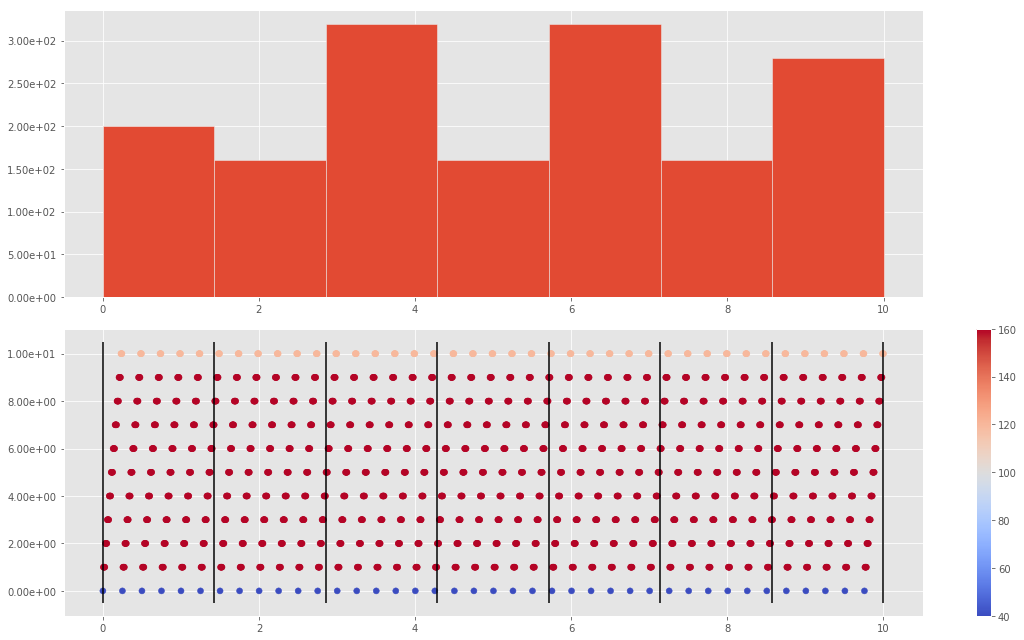

In [25]:
# Histograms lie  (with subplots)
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('ggplot')
all_lengths = FindAllPathLengths(network)

# Configuring axes and subplots
fig = plt.figure(figsize=(16, 9)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[25.7,6]) # The width ratio was manually adjusted to fit bins with lines
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,:])
ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

# Plot histogram
#plt.figure(figsize=(12.6,8))  # done by hand to try to match first figure (hist) with last one (dot diagram)
n, bins, count = ax0.hist(all_lengths, bins=7)
#ax0.ticklabel_format(style='sci', axis='y')


# Plot dot diagram
# Another approach with sizes for repeated values
size_constant = 0.0001
np_all_lengths = np.array(all_lengths)
X = np.linspace(0,10,len(all_lengths))

sizes = [all_lengths.count(num)**2.5*size_constant for num in all_lengths]
color = [all_lengths.count(num)*1 for num in all_lengths]
dot_plot = ax1.scatter(X, all_lengths, c=color, cmap="coolwarm")
ax1.vlines(bins,-0.5,10.5)
plt.colorbar(dot_plot, ax=ax1)

plt.tight_layout()

plt.show()

There you can see why the discrepancy using 7 bins, check in detail the dot diagram and you can see easily why is not constant when $0<l<L/Z$ for seven bins.

In [10]:
network1 = SmallNetwork.SmallNetwork(1000, 2, 0.02)
network2 = SmallNetwork.SmallNetwork(1000, 2, 0.2)

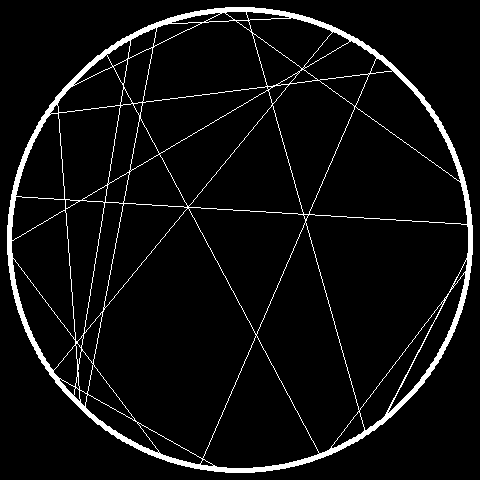

In [11]:
NetGraphics.GenerateCircleGraphImage(network1, "/tmp/prueba1.png")

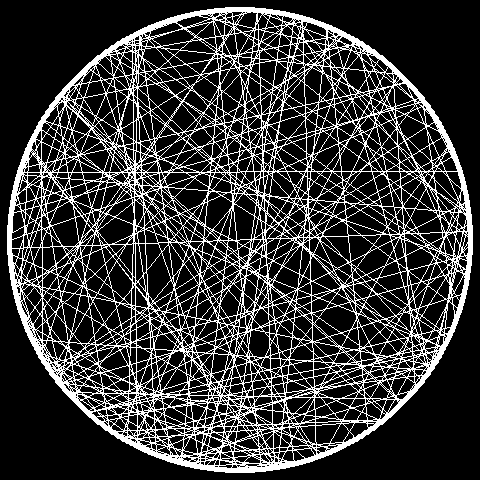

In [12]:
NetGraphics.GenerateCircleGraphImage(network2, "/tmp/prueba2.png")

## Random calculations and tests

Beyond this point all I have are random calculations and tests I made while exploring the networks

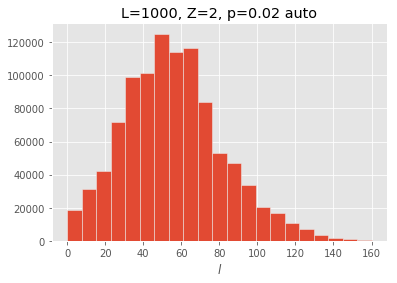

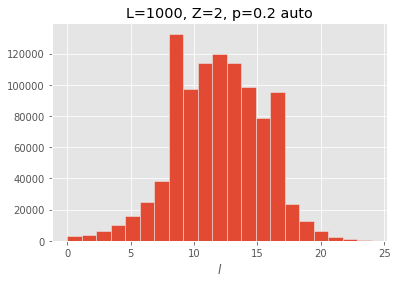

In [13]:
# Histograms
%matplotlib qt4
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('ggplot')

#plt.figure(figsize=(16,9))
plt.figure
all_lengths1 = FindAllPathLengths(network1)
plt.hist(all_lengths1, bins="sturges")
plt.title("L=1000, Z=2, p=0.02 " + str(i))
plt.xlabel(r"$l$")
plt.show()

#plt.figure(figsize=(16,9))
plt.figure()
all_lengths2 = FindAllPathLengths(network2)
plt.hist(all_lengths2, bins="sturges")
plt.title("L=1000, Z=2, p=0.2 " + str(i))
plt.xlabel(r"$l$")
plt.show()


Now we want to analyze how much does the histograms change with $p$ and how much $p$ would we need to get a "six degrees of separation" network. To accomplish that the idea is plotting histograms, calculating averages and see which comes close to the value 6, for different values of $p$. From previous histograms we can see it should be higher than $p=0.2$

In [ ]:
# Finding p for "six degrees of separation"
probabilities = np.linspace(0.001,0.1)
for p in probabilities:
    network = SmallNetwork.SmallNetwork(50,2,)
plt.semilogx

In [ ]:
np.mean(all_lengths1)

In [ ]:
np.mean(all_lengths2)

In [ ]:
N = 100 # number of tries
averages = [] # where to store the means/averages
for i in range(N):
    network_test = SmallNetwork.SmallNetwork(1000, 2, 0.1)
    all_lengths_test =FindAllPathLengths(network_test)
    #print(np.round(np.mean(all_lengths_test)))
    averages.append(np.mean(all_lengths_test))

print("Average is: ", np.round(np.mean(averages)))